In [1]:
import preprocessing as pp
import detection
import measurement

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 0. Define functions for detecting lines & circles using just HT

In [2]:
def find_lines_HT(edges, return_img=False):
    """ find lines from edge map using Hough Transform; 
        consider integrating into detection.py
    """
    
    # Detect lines using HT
    lines = cv2.HoughLinesP(edges,
                        1, np.pi/180,
                        threshold=500,    # threshold effectiveness influenced by thickness of lines, but not sensitive
                        minLineLength=10,
                        maxLineGap=1e6)

    # Check for no lines found
    if lines is None:
        return []
    else:
        return [tuple(line[0]) for line in lines]


def find_circles_HT(edges, return_img=False):
    """ find circles from edge map using Hough Transform; 
        consider integrating into detection.py
    """

    # Detect circles using HT
    r_min = 1
    circles = cv2.HoughCircles(edges,
                            method=cv2.HOUGH_GRADIENT,      #Try the ALT method, where "circle completness" is considered
                            dp=1,
                            param1=100,
                            param2=40,     # param2 effectiveness influenced by completeness & thickness of circles; pretty sensitve, and seem especially sensitive to salt & pepper noise
                            minDist=2*r_min,
                            minRadius=r_min,
                            maxRadius=1000)
    
    # Detect circles using HT
    r_min = 1
    circles = cv2.HoughCircles(edges,
                            method=cv2.HOUGH_GRADIENT_ALT,
                            dp=1,
                            param1=100,
                            param2=0.3,
                            minDist=2*r_min,
                            minRadius=r_min,
                            maxRadius=1000)

    # Check for no circles found
    if circles is None:
        return []
    else:
        circles = np.round(circles[0, :]).astype("int")
        return [(c[0], c[1], c[2]) for c in circles]
    

def draw_lines_circles(img, lines, circles):

    base_n_shapes = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB)

    # Draw lines
    if lines:   # if lines is not empty
        for (x1, y1, x2, y2) in lines:
            cv2.line(base_n_shapes, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Draw circles
    if circles:     # if circles is not empty
        for (x, y, r) in circles:
            cv2.circle(base_n_shapes, (x, y), r, (0, 255, 0), 3)
            cv2.circle(base_n_shapes, (x, y), 2, (0, 0, 255), 3)

    return base_n_shapes



# 1. Define version of functions to use: get_edges(), find_lines(), find_circles()

In [3]:
f_get_edges = pp.get_edges
f_find_lines = find_lines_HT
f_find_circles = find_circles_HT

# 2. Specify, load, & display test images to use

Base path: /Users/zack_szh/Desktop/EECS 442/EECS442_Final_Project


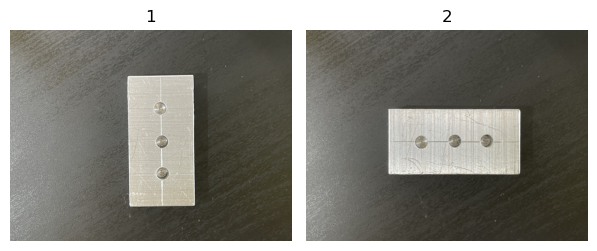

In [4]:
base_path = os.getcwd()
print("Base path:", base_path)
files = []

# parts_path = os.path.join(base_path, "data", "physical parts")
# files.append( os.path.join(parts_path, "Basic II base part.jpg") )
# files.append( os.path.join(parts_path, "mill part 2.jpeg") )
# files.append( os.path.join(parts_path, "servo mount 1.jpeg") )
# files.append( os.path.join(parts_path, "small PCB 2.jpeg") )

# parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in")
# img11 = os.path.join(parts_path, "Basic II base part 2.jpeg")
# img22 = os.path.join(parts_path, "mill part 2.jpeg")
# img33 = os.path.join(parts_path, "servo mount 1.jpeg")
# img44 = os.path.join(parts_path, "small PCB 2.jpeg")


parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in blk")
files.append( os.path.join(parts_path, "Basic II base part 1 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "Basic II base part 2 thk0.50.jpeg") )
#files.append( os.path.join(parts_path, "servo mount 1 thk0.45.jpeg") )
#files.append( os.path.join(parts_path, "small PCB 2 thk0.06.jpeg") )

titles = [str(i) for i in range(1, len(files)+1)]

imgs = detection.show_images_from_files(files, titles)

# 3. Pass each image through f_get_edges(); extract result & intermediate images

In [14]:
img_results = []
for img in imgs:
    # find edges on original image
    edges, interms = f_get_edges(img, return_interm=True)

    # find features & overlay them on edge map
    # we can perform measurement on the following outputs 
    lines = f_find_lines(edges)
    circles = f_find_circles(edges)
    img_lines = draw_lines_circles(edges, lines, [])
    img_circles = draw_lines_circles(edges, [], circles)
    # features = draw_lines_circles(edges, lines, circles)


    # doing measurement here
    measured_lines = measurement.measure_line(lines, conversion_ratio=1.0)
    measured_circles = measurement.measure_circle(circles, conversion_ratio=1.0)


    # organize results
    result = [img]
    result.extend(interms)
    result.append(edges)
    result.append(img_lines)
    result.append(img_circles)

    out = measurement.draw_measurements(img, measured_lines, measured_circles)
    plt.figure()
    plt.imshow(out)

    # result.append(features)

    # store results of this instance
    img_results.append(result)

AttributeError: module 'measurement' has no attribute 'draw_measurements'

# 4. Plot all images in organized format
images (or different objects) listed along rows;
intermediate results of each object listed along columns

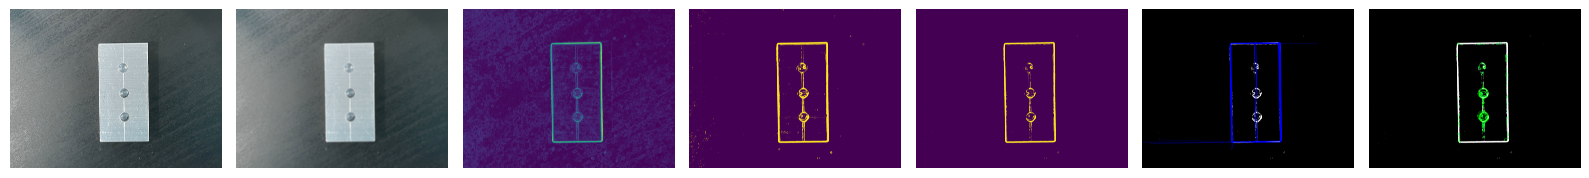

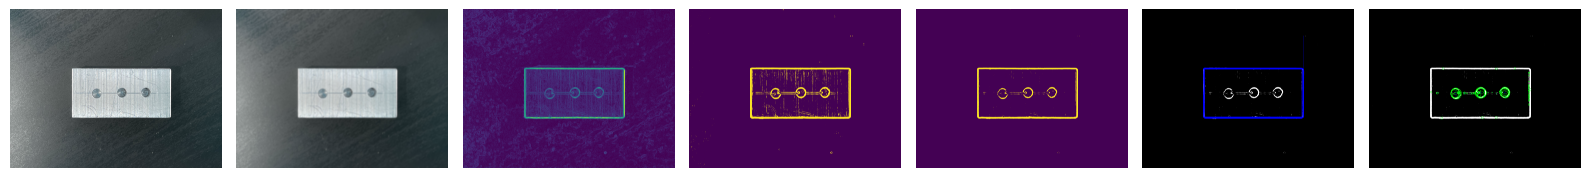

In [7]:
figsize = (16,12)    # physical part images taken from iphone should be of shape 4:3
rows = len(img_results)
cols = len(img_results[0])

for obj in img_results:
    # show rows (objs) one by one in run time
    i = 1
    plt.figure(figsize=figsize)
    for rst in obj:
        plt.subplot(1, cols, i)
        plt.imshow(rst)
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()
